Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = "me myself and I"

---

In [2]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.sparse import identity

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [6] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

## Answer to Question 1 (a)

In order to solve the problem analytically, I first assumed $u(x) = c_1\sin(x) + c_2\cos(x) + c_3\sin(3x) + c_4\cos(3x)$

Since we know that $u(0) = 0$, we then can know $c_2$ and $c_4$ are both 0, $u(x) = c_1\sin(x) + c_3\sin(3x) $

We then can know $u^{\prime \prime} = -c_1\sin(x) - 9c_3\sin(3x)$

Since we have the equation $u^{\prime \prime} + u(x) = \sin(3x)$, we then can know $-8c_3 = 1 \implies c_3 = \frac{-1}{8}$

We then substitute the other boundary condition $u(L) = 0$ then can get $0 = c_1\sin(L) - \frac{1}{8}\sin(3L) \implies c_1 = \frac{\sin(3L)}{8\sin(L)}$

We then can know

$$
u(x) = \frac{\sin(3L)}{8\sin(L)}\sin(x) - \frac{1}{8}\sin(3x)
$$

The solution is unique when L is given but actually the solution is a function of L and x. lets say solution(L), if you see it in as a function, it is not unique

**(b)** [4]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

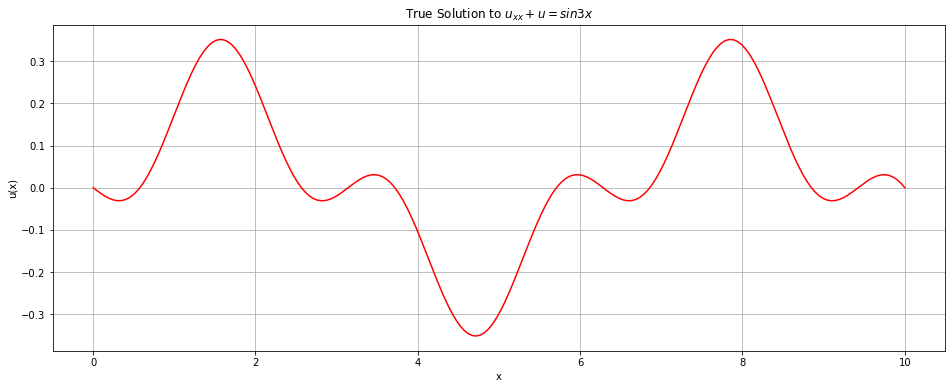

In [3]:
L = 10.
N = 200
x = numpy.linspace(0., L, N)

u_true = lambda x, L:(numpy.sin(3*L)/(8*numpy.sin(L))*numpy.sin(x)-1/8*numpy.sin(3*x))

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, u_true(x,L), 'r', label="True")
axes.set_title("True Solution to $u_{xx} + u= sin3x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.grid()


**(b)** [8] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [4]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    
    def udiff(u_var):
        """
            Solves the IVP problem using solve_ivp with adjustable initial condition u_var 
            and returns the difference between sol.y[ib] - u_b[ib]
            
        """
        u_a = [0.0, u_var]
        
        sol_ivp = solve_ivp(f, [x[0], x[-1]] ,u_a, rtol=1.e-6, atol=1.e-9,dense_output = True)
        
        return sol_ivp.y[0][-1]-u_b
    

    sol_root = root_scalar(udiff, bracket=[-10,10], method = 'brentq',rtol=1.e-6, xtol=1.e-9)
    
    sol_ivp = solve_ivp(f, [x[0], x[-1]] ,[u_a, sol_root.root], rtol=1.e-6, atol=1.e-9,dense_output = True)
    
    return sol_ivp

**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

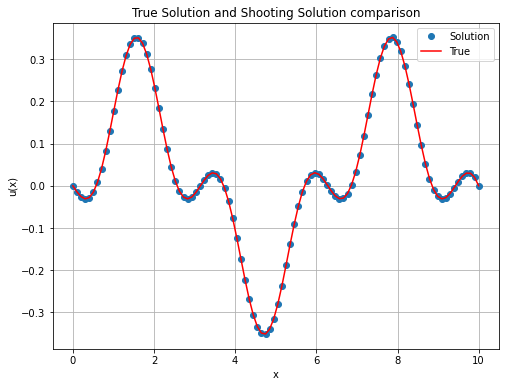

In [14]:
#  write a general shooting algorithm

a = 0.0
b = 10.0
L = 10.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = 0.0
i_a = 0
i_b = 0

u_true = lambda x, L:(numpy.sin(3*L)/(8*numpy.sin(L))*numpy.sin(x)-1/8*numpy.sin(3*x))

# RHS function
def f(x, u):
    return numpy.array([u[1], numpy.sin(3*x)-u[0]])

u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-6, atol=1.e-9).sol(x)[0]

# Plotting
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, u_sol, 'o', label = "Solution")
axes.plot(x, u_true(x,L), 'r', label="True")
axes.set_title("True Solution and Shooting Solution comparison")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
axes.legend(loc = 'best')
axes.grid()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [6]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 3.729145791793941e-07
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [7]:
# routines from class for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

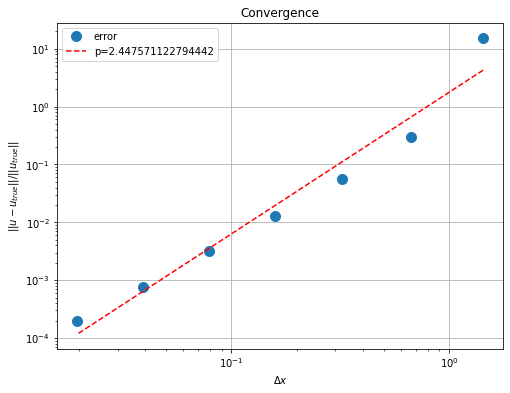

In [8]:
# Make a well labeled convergence plot that shows convergence rate of relative error vs grid spacing

a = 0.0
b = 10.0
L = 10.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = 0.0
i_a = 0
i_b = 0

u_true = lambda x:(numpy.sin(3*L)/(8*numpy.sin(L))*numpy.sin(x)-1/8*numpy.sin(3*x))

N = [ 2**n for n in range(3,10) ]
rel_err = numpy.empty(len(N))
delta_x = numpy.empty(len(N))

f_sin = lambda x: numpy.sin(3*x)

for i,n in enumerate(N):
    x = numpy.linspace(a, b, n)
    A = D2(x) + identity(n)
    A[0,0] = 1.0
    A[-1,-1] = 1.0
    f = RHS(x, f_sin, [0., 0. ])
    u = spsolve(A,f)
    rel_err[i] = numpy.linalg.norm(u - u_true(x))/numpy.linalg.norm(u_true(x))
    delta_x[i] = x[1] - x[0]
    

# calculate best fit slope and Plot result

p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o',label='error', markersize=10 )
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()


plt.show()

### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [9]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
    
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
    
    """
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

In [10]:
N = 400
x = numpy.linspace(0.,10.,N)
A = D2(x)

# wondered whether my F and J were right

def F(u):
    f =  A.dot(u) + numpy.sin(u) - numpy.sin(3*x)
    # set residual to 0 on dirichlet BCs
    f[[0,-1]] = 0
    
    return f
    
def J(u):
    
    n = len(u)
    
    return A + spdiags(numpy.cos(u),0,n,n)
    
u0 = numpy.linspace(0.,0.,N)

sol, its = newton(F,J,u0,tol=1.e-3,MAX_ITS=100,verbose=True)

k = 0, ||F|| = 14.142965796073474
k = 1, ||F|| = 0.05660516849639772
k = 2, ||F|| = 0.0016089098656531398
k = 3, ||F|| = 2.1795993913228956e-06


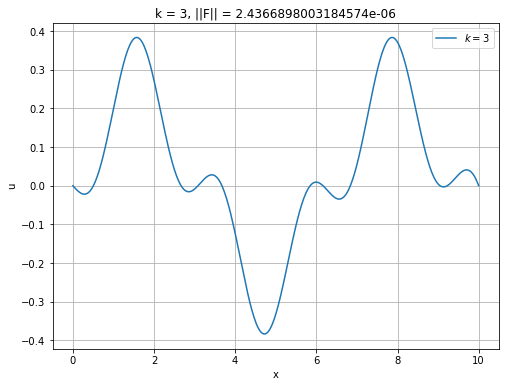

In [11]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)

axes.plot(x,sol,label='$k={}$'.format(its))
axes.legend(loc='best')
axes.set_title('k = 3, ||F|| = 2.4366898003184574e-06')
axes.set_xlabel('x')
axes.set_ylabel('u')
axes.grid()
plt.show()

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

k = 0, ||F|| = 14.142965796073474
k = 1, ||F|| = 0.05660516849639772
k = 2, ||F|| = 0.0016089098656531398
k = 3, ||F|| = 2.1795993913228956e-06
k = 0, ||F|| = 17.877331186055873
k = 1, ||F|| = 2.893701200182174
k = 2, ||F|| = 0.26517817322867615
k = 3, ||F|| = 0.009408199170947264
k = 4, ||F|| = 2.3261358128106746e-05
k = 0, ||F|| = 15.844242465796198
k = 1, ||F|| = 6.671463853406089
k = 2, ||F|| = 3.446009734125377
k = 3, ||F|| = 0.6219781476655102
k = 4, ||F|| = 0.06293980279717759
k = 5, ||F|| = 0.0010017120452104245
k = 6, ||F|| = 2.998992236762371e-07
k = 0, ||F|| = 13.847615445769632
k = 1, ||F|| = 0.2092438345704981
k = 2, ||F|| = 0.02091126328195706
k = 3, ||F|| = 0.000557541667299842
k = 0, ||F|| = 16.917579797134504
k = 1, ||F|| = 2.1467130292331165
k = 2, ||F|| = 0.4139512401417462
k = 3, ||F|| = 0.06564247275407822
k = 4, ||F|| = 0.0028040911507234926
k = 5, ||F|| = 6.438455341098699e-06
k = 0, ||F|| = 27.0919695681952
k = 1, ||F|| = 3.031502168231199
k = 2, ||F|| = 0.12805

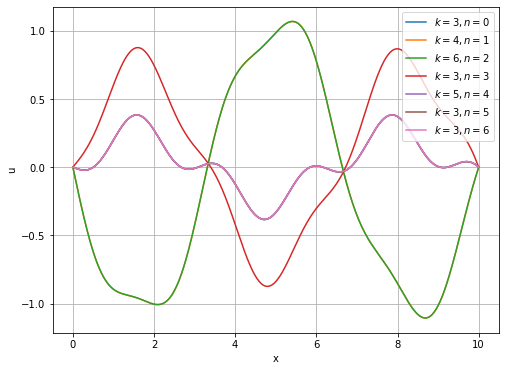

In [12]:
sol_total = []
its_total = []
fig = plt.figure(figsize=(8,6))
for n in range(7):
    
    u0 = numpy.sin(n*numpy.pi*numpy.linspace(0.,10.,N) / 10)

    sol, its = newton(F,J,u0,tol=1.e-3,MAX_ITS=100,verbose=True)
    
    sol_total.append(sol)
    its_total.append(its)
axes = fig.add_subplot(1,1,1)
for i in range(7):
    axes.plot(x,sol_total[i],label='$k={}, n = {}$'.format(its_total[i], i))
axes.legend(loc='best')
axes.set_xlabel('x')
axes.set_ylabel('u')
axes.grid()
plt.show()   



k = 0, ||F|| = 14.142965796073474
k = 1, ||F|| = 0.05660516849639772
k = 2, ||F|| = 0.0016089098656531398
k = 3, ||F|| = 2.1795993913228956e-06
k = 0, ||F|| = 17.877331186055873
k = 1, ||F|| = 2.893701200182174
k = 2, ||F|| = 0.26517817322867615
k = 3, ||F|| = 0.009408199170947264
k = 4, ||F|| = 2.3261358128106746e-05
k = 0, ||F|| = 15.844242465796198
k = 1, ||F|| = 6.671463853406089
k = 2, ||F|| = 3.446009734125377
k = 3, ||F|| = 0.6219781476655102
k = 4, ||F|| = 0.06293980279717759
k = 5, ||F|| = 0.0010017120452104245
k = 6, ||F|| = 2.998992236762371e-07
k = 0, ||F|| = 13.847615445769632
k = 1, ||F|| = 0.2092438345704981
k = 2, ||F|| = 0.02091126328195706
k = 3, ||F|| = 0.000557541667299842
k = 0, ||F|| = 16.917579797134504
k = 1, ||F|| = 2.1467130292331165
k = 2, ||F|| = 0.4139512401417462
k = 3, ||F|| = 0.06564247275407822
k = 4, ||F|| = 0.0028040911507234926
k = 5, ||F|| = 6.438455341098699e-06
k = 0, ||F|| = 27.0919695681952
k = 1, ||F|| = 3.031502168231199
k = 2, ||F|| = 0.12805

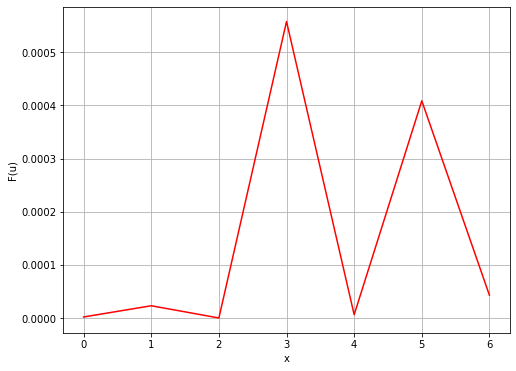

In [13]:
res_total = []

for n in range(7):
    u0 = numpy.sin(n*numpy.pi*numpy.linspace(0.,10.,N) / 10)
    sol, its = newton(F,J,u0,tol=1.e-3,MAX_ITS=100,verbose=True)
    res_total.append(numpy.linalg.norm(F(sol)))

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)

axes.plot([0,1,2,3,4,5,6],res_total,'r')

axes.set_xlabel('x')
axes.set_ylabel('F(u)')
axes.grid()
plt.show()  

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?